# Mapping Capstone Project: Semantic Segmentation to Map Floodwater from Radar Imagery

This project is an extension of DrivenData.org's competition on mapping floodwater from Satellite-Aperture Radar Imagery. The data prep and model code is based on the benchmark blog post from the competition, which you can find here: https://www.drivendata.co/blog/detect-floodwater-benchmark/. However, I've made a lot of changes, and all of the other code is mine.

The challenges for this project were less to do with training like it was done in the blog post, but:

1. Preparing the data for SageMaker
2. Modifying the training code for use in SageMaker
3. Training 2 models using HyperparameterTuning and choosing the best model (I originally wanted to do an ensemble model, but after tinkering too much and finding the documentation lacking, I decided to just go with the best model). **Important Note**: to make things easier for the project reviewer, I have taken the best model from my Hyperparameter Tuning jobs and will simply train that model in this notebook. This will save time since training more than one model can take up a lot of time. That said, all the Hyperparameter Tuning code is still there and you can uncomment it if you would like to use the Hyperparameter Tuning instead.
4. Doing inference on the image (.tif) data
5. Creating a Streamlit app to do inference

I ran into a lot of bugs and SageMaker specific issues while working on this project and learned a lot. I will try to note each part where I learned something and some of the challenges I had.

## IMPORTANT NOTE BEFORE RUNNING THIS CODE

**Note:** This part is not necessary for the project reviewer.

Since we trained two models, we will be picking the best for inference. However, when the model is instantiated, we need to put the name of the architecture used for training in `model.py` in the `serve` directory. I tried to do this with environment variables in the deployment code, but I was not able to make it work. 

The documentation is quite bad and I could not find an answer to passing environment variables anywhere online. I tried many things, but eventually I had to move on.

Therefore, to run this notebook straight-through, you need to make sure that: you update the architecture name to whatever architecture is the best. Simply copy-paste the output of the cell above. In this case, the best model was using the Unet architecture. That is the architecture currently used in the inference code. If the best model you train is also the Unet architecture, you don't need to change a thing. However, if it is "DeepLabV3", then you need to go to `./serve/model.py` and replace `self.architecture = 'Unet'` in `__init__` with `self.architecture = 'DeepLabV3'`.

The Unet architecture typically always performed better, but it may be different in your case. Therefore, run the model up until "Preparing our Code for Inference" and then make the necessary edit if the better model used the DeepLabV3 architecture.

## Important regarding GPU Instance

At some point during the project, I reached the quota for the GPU usage provided by Udacity. So I setup my own AWS account and asked for  a GPU quota increase. I asked for a `ml.p3.2xlarge`. That is what I used for the rest of the project. I do not have a `ml.p2.xlarge` like what Udacity uses. This may lead to issues with CUDA (since I had a lot of issues with it once I switched GPUs). If there are issues, it is likely due to the batch size. I was able to put the batch size to 32 when I was using `ml.p2.xlarge`, but I had to drop it to 8 when I started using `ml.p3.2xlarge`. I've changed the GPU back to `ml.p2.xlarge`, but I have not tested the code with a batch size of 8 when using that GPU. I don't want to bump it up to 32 since I'm concerned I might have made changes that would make 32 no longer work. I expect that a batch size of 8 will work, but it will just make training a little slower than 32.

# Installing Requirements

* PyTorch Lightning: Our deep learning framework (built on top of PyTorch, removes boilerplate code)
* Segmentation Models: pre-trained segmentation models
* pandas_path: Path style access for pandas
* Rasterio: For interacting with geospatial data
* Albumentations: For image transforms during model training
* Wandb: For model monitoring during training (wandb code has been commented out to make notebook easier to run for others)

In [1]:
pip install -U sagemaker --quiet

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_latest_p36/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install pytorch-lightning==1.4.5 git+https://github.com/qubvel/segmentation_models.pytorch pandas_path==0.3.0 rasterio==1.2.6 albumentations==0.1.12 wandb --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
s3fs 2021.4.0 requires fsspec==2021.04.0, but you have fsspec 2021.10.1 which is incompatible.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_latest_p36/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install tifffile

     |████████████████████████████████| 148 kB 25.8 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_latest_p36/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


Restarting the kernel to use the newly installed packages:

In [4]:
from IPython.display import display_html
def restartkernel() :
    display_html("<script>Jupyter.notebook.kernel.restart()</script>",raw=True)

# Imports

In [5]:
import json
import boto3
import sagemaker
from sagemaker.pytorch import PyTorch

# SageMaker Environment Setup

In [6]:
# Initializes SageMaker session which holds context data
sagemaker_session = sagemaker.Session()

# Our IAM role that allows us to access things
role = sagemaker.get_execution_role()

# Creating an S3 bucket to put our data in
bucket = sagemaker_session.default_bucket()

# Region name
region = sagemaker.session.Session().boto_region_name

In [7]:
print(sagemaker_session)
print(role)
print(bucket)
print(region)

arn:aws:iam::034262493329:role/service-role/AmazonSageMaker-ExecutionRole-20210810T151351
sagemaker-us-east-1-034262493329
us-east-1


# 1. Explore The Data

Let's start exploring the data! But first, we need to download the data.

In [8]:
import os
if not os.path.exists('../data/'):
    zip_filename = 'floodwater-data.zip'

    !wget https://map-floodwater-driven-data-competition.s3.amazonaws.com/floodwater-data/{zip_filename} -P ../data
    !unzip -qq ../data/{zip_filename} -d ../data

In [9]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# This is where our downloaded images and metadata live locally
DATA_PATH = Path("../data/floodwater-data/")

The following section will contain code copied from the blog post mentioned in the introduction, but with some tweeks to make it work in SageMaker.

In [10]:
train_metadata = pd.read_csv(
    DATA_PATH / "flood-training-metadata.csv", parse_dates=["scene_start"]
)

In [11]:
train_metadata.head()

,image_id,chip_id,flood_id,polarization,location,scene_start
0,awc00_vh,awc00,awc,vh,Bolivia,2018-02-15
1,awc00_vv,awc00,awc,vv,Bolivia,2018-02-15
2,awc01_vh,awc01,awc,vh,Bolivia,2018-02-15
3,awc01_vv,awc01,awc,vv,Bolivia,2018-02-15
4,awc02_vh,awc02,awc,vh,Bolivia,2018-02-15


In [12]:
# check if there are any duplicate rows
ids = train_metadata['image_id']
train_metadata[ids.isin(ids[ids.duplicated()])].sort_values("image_id")

,image_id,chip_id,flood_id,polarization,location,scene_start


Looks like there are no duplicates!

Polarization VV (vertical transmit, vertical receive) means that the light that was sent to Earth was in a vertical polarization and it remained vertical after being reflected and going through clouds, etc. This is not necessarily the case and may change depending on the matter which the light is being reflected off of. The light and end up being polarized in either horizontal, circular-left, and circular-right polarization.

It may also be the case that light which is sent as 100% vertical polarization may come back as x% vertically polarized and y% horizontally polarized. This means that the detectors will detect less intensity in the vertical polarization (compared to what it sent), and the rest is either lost intensity through reflection, absorption or changing to another polarization (or unpolarized).

In [13]:
train_metadata.shape

(1084, 6)

In [14]:
train_metadata.chip_id.nunique() # each unique chip has both vv and vh band (542 * 2 = 1084)

542

In [15]:
flood_counts = train_metadata.groupby("flood_id")["chip_id"].nunique()
flood_counts.describe()

count    13.000000
mean     41.692308
std      19.947367
min      15.000000
25%      28.000000
50%      32.000000
75%      65.000000
max      69.000000
Name: chip_id, dtype: float64

The training data include chips from 13 flood events. We have anywhere from 15 to 69 chips (30 to 138 images) per unique event, with half of events containing fewer than 32 chips (64 images).

In [16]:
location_counts = (
    train_metadata.groupby("location")["chip_id"].nunique().sort_values(ascending=False)
)

Text(0.5, 1.0, 'Number of Chips by Location')

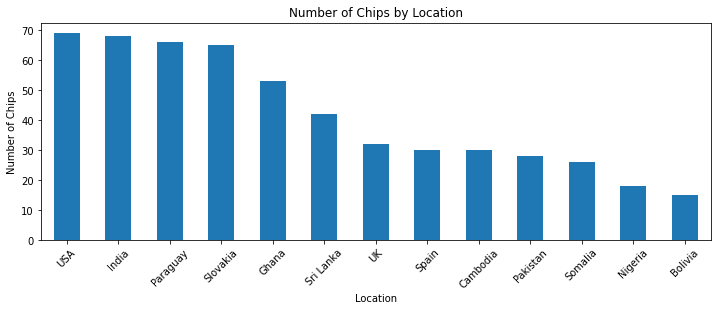

In [17]:
plt.figure(figsize=(12, 4))
location_counts.plot(kind="bar")
plt.xticks(rotation=45)
plt.xlabel("Location")
plt.ylabel("Number of Chips")
plt.title("Number of Chips by Location")

We have a variety of location that definitely have different types of land, so it would be important to train our models to take that into account and test our models on different locations so that we can find out where needs to be the most improvement.

Some locations have way more chips for floods than others, so that means the data is likely much richer in those areas.

However, since we are more focused on creating an end-to-end project, we will refrain from spending time on such things. In a normal project, we would do the same; we would only start focusing on details like that to improve performance once we have a working end-to-end pipeline. So, in this case we are only really exploring the data to get a sense of what the data is about so that we can at least get some training runs going, and we would come back and take advantage of the particulars of this dataset later on.

In [18]:
year = train_metadata.scene_start.dt.year
year_counts = train_metadata.groupby(year).nunique()
year_counts

,image_id,chip_id,flood_id,polarization,location,scene_start
scene_start,,,,,,
2016,136,68,1,2,1,1
2017,140,70,2,2,2,2
2018,416,208,6,2,6,6
2019,262,131,3,2,3,3
2020,130,65,1,2,1,1


In [19]:
train_metadata.groupby("flood_id").nunique()

,image_id,chip_id,polarization,location,scene_start
flood_id,,,,,
awc,30,15,2,1,1
ayt,36,18,2,1,1
coz,56,28,2,1,1
hbe,138,69,2,1,1
hxu,52,26,2,1,1
jja,132,66,2,1,1
kuo,130,65,2,1,1
pxs,136,68,2,1,1
qus,60,30,2,1,1


The training data cover flood events that occurred between 2016 and 2020. Images for each event were captured on the same day.

# Loading and Exploring Images

Next, we can begin exploring the image data. We'll add a `feature_path` column to our training metadata, which will contain a `Path` object with the full path to a training image. We'll also add a `label_path` column that points to each image's corresponding water label.

In [20]:
from pandas_path import path

In [21]:
train_metadata.chip_id

0       awc00
1       awc00
2       awc01
3       awc01
4       awc02
        ...  
1079    wvy29
1080    wvy30
1081    wvy30
1082    wvy31
1083    wvy31
Name: chip_id, Length: 1084, dtype: object

In [22]:
train_metadata.chip_id.path.with_suffix(".tif")

0       awc00.tif
1       awc00.tif
2       awc01.tif
3       awc01.tif
4       awc02.tif
          ...    
1079    wvy29.tif
1080    wvy30.tif
1081    wvy30.tif
1082    wvy31.tif
1083    wvy31.tif
Name: chip_id, Length: 1084, dtype: object

In [23]:
list_of_img_paths = list(str(DATA_PATH / "train_labels") / train_metadata.chip_id.path.with_suffix(".tif").path)
list_of_img_paths[:5]

['../data/floodwater-data/train_labels/awc00.tif',
 '../data/floodwater-data/train_labels/awc00.tif',
 '../data/floodwater-data/train_labels/awc01.tif',
 '../data/floodwater-data/train_labels/awc01.tif',
 '../data/floodwater-data/train_labels/awc02.tif']

In [24]:
train_metadata["feature_path"] = (
    str(DATA_PATH / "train_features") /
    train_metadata.image_id.path.with_suffix(".tif").path
)

In [25]:
train_metadata["label_path"] = (
    str(DATA_PATH / "train_labels") /
    train_metadata.chip_id.path.with_suffix(".tif").path
)

A GeoTIFF is a raster image file that contains geographic metadata describing the location of the image. This metadata can include bounding coordinates, an affine transform, and a coordinate reference system (CRS) projection. The package [rasterio](https://rasterio.readthedocs.io/en/latest/) makes it easy to interact with our geospatial raster data.

In [26]:
import rasterio

In [27]:
train_metadata.feature_path[0]

'../data/floodwater-data/train_features/awc00_vh.tif'

In [28]:
# Examine an arbitrary image
image_path = train_metadata.feature_path[0]

In [29]:
with rasterio.open(image_path) as img:
  metadata = img.meta
  bounds = img.bounds
  data = img.read(1) # read a single polarization band

In [30]:
metadata

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': 0.0,
 'width': 512,
 'height': 512,
 'count': 1,
 'crs': CRS.from_epsg(32720),
 'transform': Affine(10.0, 0.0, 314030.0,
        0.0, -10.0, 8585890.0)}

In [31]:
bounds

BoundingBox(left=314030.0, bottom=8580770.0, right=319150.0, top=8585890.0)

In [32]:
data

array([[-16.208015 , -17.71951  , -16.281353 , ...,   0.       ,
          0.       ,   0.       ],
       [-15.3288965, -18.231857 , -16.451893 , ...,   0.       ,
          0.       ,   0.       ],
       [-15.353134 , -16.88831  , -15.585904 , ...,   0.       ,
          0.       ,   0.       ],
       ...,
       [-15.741662 , -15.230668 , -13.455255 , ...,   0.       ,
          0.       ,   0.       ],
       [-15.498258 , -14.100984 , -13.11027  , ...,   0.       ,
          0.       ,   0.       ],
       [-16.055603 , -14.1121   , -14.76084  , ...,   0.       ,
          0.       ,   0.       ]], dtype=float32)

We will need to be able to identify pixels with missing data, since we will only be evaluated on predictions made for valid input pixels. The metadata tells us that a value of 0.0 represents missing data for an input image. In rasterio, you can access two different kinds of missing data masks. The first mask is a GDAL-style mask, in which non-zero elements (typically 255) indicate that the corresponding data elements are valid.

In [33]:
with rasterio.open(image_path) as img:
  gdal_mask = img.dataset_mask()

In [34]:
gdal_mask

array([[255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       ...,
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0]], dtype=uint8)

The second mask is a numpy masked array, which has the inverse sense: `True` values indicate that the corresponding data elements are invalid. To load the data as a numpy masked array and access this type of missing data mask, simply pass a `masked` flag to `read`.

In [35]:
with rasterio.open(image_path) as img:
  numpy_mask = img.read(1, masked=True)

In [36]:
numpy_mask

masked_array(
  data=[[-16.20801544189453, -17.71950912475586, -16.281352996826172,
         ..., --, --, --],
        [-15.328896522521973, -18.231857299804688, -16.451892852783203,
         ..., --, --, --],
        [-15.353134155273438, -16.888309478759766, -15.585904121398926,
         ..., --, --, --],
        ...,
        [-15.74166202545166, -15.230668067932129, -13.455254554748535,
         ..., --, --, --],
        [-15.498257637023926, -14.100983619689941, -13.110269546508789,
         ..., --, --, --],
        [-16.05560302734375, -14.112099647521973, -14.76084041595459,
         ..., --, --, --]],
  mask=[[False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]],
  fill_value=0.0,
  dtype=f

Pixel values represent energy that was reflected back to the satellite measured in decibels. To better visualize the bands or channels of Sentinel-1 images, we will create a [false color composite](https://earthobservatory.nasa.gov/features/FalseColor) by treating the two bands and their ratio as red, green, and blue channels, respectively. We will prepare a few helper functions to visualize the data.

In [37]:
import warnings

warnings.filterwarnings("ignore")

In [38]:
# Helper functions for visualizing Sentinel-1 images
def scale_img(matrix):
    """
    Returns a scaled (H, W, D) image that is visually inspectable.
    Image is linearly scaled between min_ and max_value, by channel.

    Args:
        matrix (np.array): (H, W, D) image to be scaled

    Returns:
        np.array: Image (H, W, 3) ready for visualization
    """
    # Set min/max values
    min_values = np.array([-23, -28, 0.2])
    max_values = np.array([0, -5, 1])

    # Reshape matrix
    w, h, d = matrix.shape
    matrix = np.reshape(matrix, [w * h, d]).astype(np.float64)

    # Scale by min/max
    matrix = (matrix - min_values[None, :]) / (
        max_values[None, :] - min_values[None, :]
    )
    matrix = np.reshape(matrix, [w, h, d])

    # Limit values to 0/1 interval
    return matrix.clip(0, 1)


def create_false_color_composite(path_vv, path_vh):
    """
    Returns a S1 false color composite for visualization.

    Args:
        path_vv (str): path to the VV band
        path_vh (str): path to the VH band

    Returns:
        np.array: image (H, W, 3) ready for visualization
    """
    # Read VV/VH bands
    with rasterio.open(path_vv) as vv:
        vv_img = vv.read(1)
    with rasterio.open(path_vh) as vh:
        vh_img = vh.read(1)

    # Stack arrays along the last dimension
    s1_img = np.stack((vv_img, vh_img), axis=-1)

    # Create false color composite
    img = np.zeros((512, 512, 3), dtype=np.float32)
    img[:, :, :2] = s1_img.copy()
    img[:, :, 2] = s1_img[:, :, 0] / s1_img[:, :, 1]

    return scale_img(img)


def display_specific_chip(chip_num):
    """
    Plots a 3-channel representation of VV/VH polarizations as a single chip (image 1).
    Overlays a chip's corresponding water label (image 2).

    Args:
        random_state (int): random seed used to select a chip

    Returns:
        plot.show(): chip and labels plotted with pyplot
    """
    f, ax = plt.subplots(1, 2, figsize=(9, 9))

    # Select a random chip from train_metadata
    # sample(random_state=random_state)
    random_chip = train_metadata.chip_id.iloc[chip_num]#.values[0]
    chip_df = train_metadata[train_metadata.chip_id == random_chip]

    # Extract paths to image files
    vv_path = chip_df[chip_df.polarization == "vv"].feature_path.values[0]
    vh_path = chip_df[chip_df.polarization == "vh"].feature_path.values[0]
    label_path = chip_df.label_path.values[0]

    # Create false color composite
    s1_img = create_false_color_composite(vv_path, vh_path)

    # Visualize features
    ax[0].imshow(s1_img)
    ax[0].set_title("S1 Chip", fontsize=14)

    # Load water mask
    with rasterio.open(label_path) as lp:
        lp_img = lp.read(1)

    # Mask missing data and 0s for visualization
    label = np.ma.masked_where((lp_img == 0) | (lp_img == 255), lp_img)

    # Visualize water label
    ax[1].imshow(s1_img)
    ax[1].imshow(label, cmap="cool", alpha=1)
    ax[1].set_title("S1 Chip with Water Label", fontsize=14)

    plt.tight_layout(pad=5)
    plt.show()

In [39]:
random_chip = train_metadata.chip_id.sample(7).values[0]
chip_df = train_metadata[train_metadata.chip_id == random_chip]
chip_df['feature_path'].iloc[0]

'../data/floodwater-data/train_features/hxu19_vh.tif'

Let's inspect a few chips and their water labels.

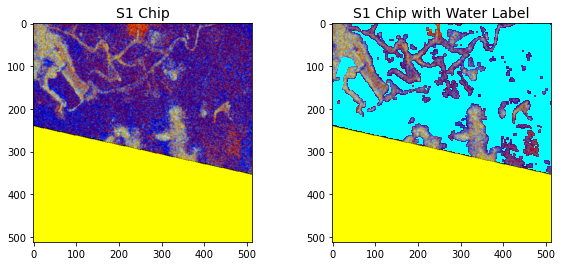

In [40]:
display_specific_chip(6)

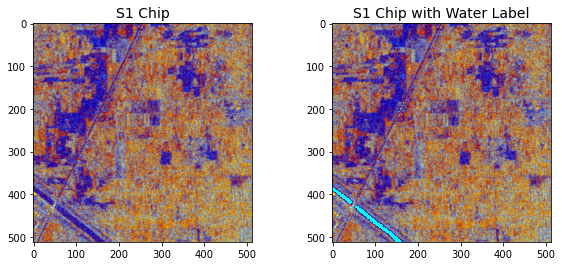

In [41]:
display_specific_chip(66)

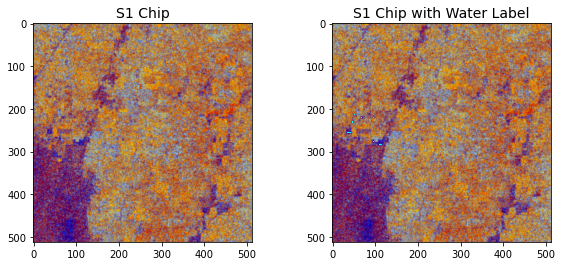

In [42]:
display_specific_chip(90)

You'll notice that some images contain high floodwater coverage, while others have little to no coverage. Water spread may be concentrated in one location or spread out, depending on a variety of surface characteristics like topography, terrain, and ground cover. Missing pixels are displayed in yellow.

In [43]:
# Confirming that the images are 512 x 512 pixels.

# examples = [rasterio.open(train_metadata.feature_path[x]) for x in range(len(train_metadata.feature_path))]
# for image in examples:
#     assert image.shape == (512, 512)

# The images are all indeed (512, 512) in shape.
# We are now commenting this code since it takes over 6 minutes to run and
# we've already answered our question.

# Split the Data

Here we will split the data in a simple way, but if we wanted to really test and improve our model, we would create a set of train/test/validation sets so that we can compare all the models on different slice of data.

In [44]:
import pytorch_lightning
from pytorch_lightning import seed_everything
import random

In [45]:
# we use a random seed for the dataset split
seed_everything(9) # set a seed for reproducibility, seeds torch, numpy, python.random

Global seed set to 9


9

In [46]:
# sample 3 random floods for validation set
flood_ids = train_metadata.flood_id.unique().tolist()
val_flood_ids = random.sample(flood_ids, 3)
val_flood_ids

['pxs', 'qxb', 'jja']

In [47]:
val = train_metadata[train_metadata.flood_id.isin(val_flood_ids)]
train = train_metadata[~train_metadata.flood_id.isin(val_flood_ids)]

Since a single input to our model will contain both VV and VH bands, let's identify our input paths by `chip_id`.

In [48]:
# Helper function for pivoting out paths by chip
def get_paths_by_chip(image_level_df):
    """
    Returns a chip-level dataframe with pivoted columns
    for vv_path and vh_path.

    Args:
        image_level_df (pd.DataFrame): image-level dataframe

    Returns:
        chip_level_df (pd.DataFrame): chip-level dataframe
    """
    paths = []
    for chip, group in image_level_df.groupby("chip_id"):
        vv_path = group[group.polarization == "vv"]["feature_path"].values[0]
        vh_path = group[group.polarization == "vh"]["feature_path"].values[0]
        paths.append([chip, vv_path, vh_path])
    return pd.DataFrame(paths, columns=["chip_id", "vv_path", "vh_path"])

In [49]:
# Separate features from labels
val_x = get_paths_by_chip(val)
val_y = val[["chip_id", "label_path"]].drop_duplicates().reset_index(drop=True)

train_x = get_paths_by_chip(train)
train_y = train[["chip_id", "label_path"]].drop_duplicates().reset_index(drop=True)

In [50]:
train_x

,chip_id,vv_path,vh_path
0,awc00,../data/floodwater-data/train_features/awc00_v...,../data/floodwater-data/train_features/awc00_v...
1,awc01,../data/floodwater-data/train_features/awc01_v...,../data/floodwater-data/train_features/awc01_v...
2,awc02,../data/floodwater-data/train_features/awc02_v...,../data/floodwater-data/train_features/awc02_v...
3,awc03,../data/floodwater-data/train_features/awc03_v...,../data/floodwater-data/train_features/awc03_v...
4,awc04,../data/floodwater-data/train_features/awc04_v...,../data/floodwater-data/train_features/awc04_v...
...,...,...,...
361,wvy27,../data/floodwater-data/train_features/wvy27_v...,../data/floodwater-data/train_features/wvy27_v...
362,wvy28,../data/floodwater-data/train_features/wvy28_v...,../data/floodwater-data/train_features/wvy28_v...
363,wvy29,../data/floodwater-data/train_features/wvy29_v...,../data/floodwater-data/train_features/wvy29_v...
364,wvy30,../data/floodwater-data/train_features/wvy30_v...,../data/floodwater-data/train_features/wvy30_v...


In [51]:
train_y

,chip_id,label_path
0,awc00,../data/floodwater-data/train_labels/awc00.tif
1,awc01,../data/floodwater-data/train_labels/awc01.tif
2,awc02,../data/floodwater-data/train_labels/awc02.tif
3,awc03,../data/floodwater-data/train_labels/awc03.tif
4,awc04,../data/floodwater-data/train_labels/awc04.tif
...,...,...
361,wvy27,../data/floodwater-data/train_labels/wvy27.tif
362,wvy28,../data/floodwater-data/train_labels/wvy28.tif
363,wvy29,../data/floodwater-data/train_labels/wvy29.tif
364,wvy30,../data/floodwater-data/train_labels/wvy30.tif


In [52]:
# Confirm approx. 1/3 of images are in the validation set
len(val_x) / (len(val_x) + len(train_x)) * 100

32.47232472324723

# Send Data to S3

In [53]:
# s3 bucket path (we use this for model training, instead of using local files)
s3_bucket_path = 's3://map-floodwater-driven-data-competition/floodwater-data/'

In [54]:
train_df = train_x.merge(train_y)
val_df = val_x.merge(val_y)
train_df.head()

,chip_id,vv_path,vh_path,label_path
0,awc00,../data/floodwater-data/train_features/awc00_v...,../data/floodwater-data/train_features/awc00_v...,../data/floodwater-data/train_labels/awc00.tif
1,awc01,../data/floodwater-data/train_features/awc01_v...,../data/floodwater-data/train_features/awc01_v...,../data/floodwater-data/train_labels/awc01.tif
2,awc02,../data/floodwater-data/train_features/awc02_v...,../data/floodwater-data/train_features/awc02_v...,../data/floodwater-data/train_labels/awc02.tif
3,awc03,../data/floodwater-data/train_features/awc03_v...,../data/floodwater-data/train_features/awc03_v...,../data/floodwater-data/train_labels/awc03.tif
4,awc04,../data/floodwater-data/train_features/awc04_v...,../data/floodwater-data/train_features/awc04_v...,../data/floodwater-data/train_labels/awc04.tif


Here we update the filepaths for our feature and label paths. The path we use is exactly the one that will be created for each file during training. The data will be downloaded from S3 and downloaded to `/opt/ml/input/data/data_s3_uri/`.

In [55]:
for col in train_df.columns[1:]:
    train_df[col] = train_df[col].apply(lambda x: '/opt/ml/input/data/data_s3_uri/' + '/'.join(x.split('/')[3:]))
    val_df[col] = val_df[col].apply(lambda x: '/opt/ml/input/data/data_s3_uri/' + '/'.join(x.split('/')[3:]))
train_df.head()

,chip_id,vv_path,vh_path,label_path
0,awc00,/opt/ml/input/data/data_s3_uri/train_features/...,/opt/ml/input/data/data_s3_uri/train_features/...,/opt/ml/input/data/data_s3_uri/train_labels/aw...
1,awc01,/opt/ml/input/data/data_s3_uri/train_features/...,/opt/ml/input/data/data_s3_uri/train_features/...,/opt/ml/input/data/data_s3_uri/train_labels/aw...
2,awc02,/opt/ml/input/data/data_s3_uri/train_features/...,/opt/ml/input/data/data_s3_uri/train_features/...,/opt/ml/input/data/data_s3_uri/train_labels/aw...
3,awc03,/opt/ml/input/data/data_s3_uri/train_features/...,/opt/ml/input/data/data_s3_uri/train_features/...,/opt/ml/input/data/data_s3_uri/train_labels/aw...
4,awc04,/opt/ml/input/data/data_s3_uri/train_features/...,/opt/ml/input/data/data_s3_uri/train_features/...,/opt/ml/input/data/data_s3_uri/train_labels/aw...


Below is the paths the files will be during training. The `dataset.py` script in `train` and `serve` will be used to get the files from those locations.

In [56]:
print(train_df['vv_path'][0])
print(train_df['vh_path'][0])
print(train_df['label_path'][0])

/opt/ml/input/data/data_s3_uri/train_features/awc00_vv.tif
/opt/ml/input/data/data_s3_uri/train_features/awc00_vh.tif
/opt/ml/input/data/data_s3_uri/train_labels/awc00.tif


In [57]:
# name of directory we created to save our data
data_dir = '../data/floodwater-data/'

In [58]:
# saving the train and val dataframes locally so that we can upload them to S3
train_df.to_csv(data_dir + 'train_df.csv')
val_df.to_csv(data_dir + 'val_df.csv')

In [59]:
# # takes about 2min30s
# s3_uploader = sagemaker.s3.S3Uploader()

# # upload all data to S3
# data_s3_uri = s3_uploader.upload(local_path=data_dir, desired_s3_uri=f"s3://{bucket}/floodwater_data")
# print(data_s3_uri)

In [59]:
# Use uri below if data has already been uploaded. No need to upload the data every time we run this notebook.
data_s3_uri = 's3://sagemaker-us-east-1-034262493329/floodwater_data'

# Build the Model

Since the goal of this project is more about using SageMaker's capabilities rather than focusing all of our attention on building a model with the highest performance, we will opt for training simple models. As described in the benchmark blog post, we can use a pre-trained backbone + head architecture to train our model. We will be training two models in order to test out SageMaker's HyperparameterTuner. The only thing we will change between the two models is the head architecture. We'll train one model with the popular Unet architecture (the simple version) and another with the DeepLab architecture (since it's known to do quite well on satellite imagery).

For those who want a bit more clarity of this approach: we are doing transfer learning using a pretrained "backbone" model and connecting the output of the backbone to an untrained head architecture to fine-tune on our particular dataset. The backbone we will be using is the simple ResNet34 since it will train faster, but still give us decent results. ResNet34 has been trained on different datasets, but it is primarily known for it's performance on ImageNet (as well as most similar models). Therefore, we will be using a pre-trained ResNet34 that was trained on ImageNet.

We will be applying data augmentation techniques during training (using the albumentations library). We do this to prevent overfitting during training. We'll increase the size of our training data by applying a set of data augmentations to our input, including random cropping, random 90 degree rotations, and horizontal and vertical flipping.

We'll be using the PyTorch Lightning library to train our model. After a lot of trial and error to get the requirements.txt file in good shape, we were able to make it work in SageMaker. My main issue was that I was trying to install a torch version that was different than the containers prepared by AWS. This led to some issues with Horovod since Horovod needs to be installed with the same underlying versions as torch. Also, since I was trying to use earlier versions of torch (to try to circumvent the Horovod issue), I ran into issues with data types since torch changed how its Tensor worked over time. Eventually, I realized that I could install the correct Horovod version by including Horovod[pytorch] in the requirements.txt file. However, even that was not necessary as I was able to make the code work with torch 1.8.0., which AWS has made a container containing it. So, now the requirements.txt file is a lot more simple and I can use the code similar to the blog post without worrying about data types and such. I just wanted to document what happened in case someone ever has a similar issue.

Anyway, back to PyTorch Lightning. We use it because it deals with a lot of boilerplate code that we would typically need to write ourselves in pure PyTorch (particularly the training loop). Our training process is divided into two main parts. The `dataset.py` file in `train` will load the data and then that gets loaded onto the GPU with a DataLoader object. The second part is the training loop which `FloodModel` in `model.py` takes care of.

From the blog post:

> Next, we will create a custom class to define our training loss function and a helper function to calculate our validation metric, Intersection over Union (IOU).

> For training, we will use a standard mixture of 50% cross-entropy loss and 50% dice loss, which improves learning when there are unbalanced classes. Since our images tend to contain more non-water than water pixels, this metric should be a good fit. Broadly speaking, cross-entropy loss evaluates differences between predicted and ground truth pixels and averages over all pixels, while dice loss measures overlap between predicted and ground truth pixels and divides a function of this value by the total number of pixels in both images. This custom class will inherit torch.nn.Module, which is the base class for all neural network modules in PyTorch. A lower XEDiceLoss score indicates better performance.

> For validation, we will calculate IOU. As a reminder, IOU represents the size of the intersection divided by the size of the union of pixels. A higher IOU indicates better performance.


In [60]:
!pygmentize train/loss_functions.py

import torch
import torch.nn as nn
from torch import tensor


class XEDiceLoss(nn.Module):
    """
    Computes (0.5 * CrossEntropyLoss) + (0.5 * DiceLoss).
    """

    def __init__(self):
        super().__init__()
        self.xe = nn.CrossEntropyLoss(reduction="none")

    def forward(self, pred, true):
        valid_pixel_mask = true.ne(255) # valid pixel mask

#         print(true)
#         print(type(true))
#         print(tensor(0, dtype=torch.double).cuda())
#         print(type(tensor(0, dtype=torch.double).cuda()))
        # Cross-entropy loss
        temp_true = torch.where((true == 255), 0, true) # cast 255 to 0 temporarily
        xe_loss = self.xe(pred, temp_true).float()
        xe_loss = xe_loss.masked_select(valid_pixel_mask).mean()

        # Dice loss
        pred = torch.softmax(pred, dim=1)[:, 1]
        pred = pred.masked_select(valid_pixel_mask)
        true = true.masked_select(valid_pixel_mask)
        dice_loss = 1 - (2.0 * torch.sum(pred * true)) / (torch.s

In [61]:
!pygmentize train/metrics.py

import numpy as np


def intersection_and_union(pred, true):
    """
    Calculates intersection and union for a batch of images.

    Args:
        pred (torch.Tensor): a tensor of predictions
        true (torch.Tensor): a tensor of labels

    Returns:
        intersection (int): total intersection of pixels
        union (int): total union of pixels
    """
    valid_pixel_mask = true.ne(255) # valid pixel mask
    true = true.masked_select(valid_pixel_mask).to("cpu")
    pred = pred.masked_select(valid_pixel_mask).to("cpu")

    # Intersection and union totals
    intersection = np.logical_and(true, pred)
    union = np.logical_or(true, pred)
    return intersection.sum(), union.sum()


## Training Code

Let's have a look at our training script:

In [158]:
!pygmentize train/train.py

import argparse
import os
import pandas as pd
import torch
import torch.nn as nn
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning import seed_everything
import wandb
from datetime import datetime

from model import FloodModel


if __name__ =='__main__':
    
    # Removing this for Udacity, but useful for further usage
#     wandb.login() # This will look for WANDB_API_KEY env variable provided by secrets.env
#     wandb.init(project="Driven-Data-Floodwater-Mapping", entity="effective-altruism-techs")

    parser = argparse.ArgumentParser()
    
    # Below is only used when we are training one model.
    
    # hyperparameters sent by the client are passed as command-line arguments to the script.
    parser.add_argument('--architecture', type=str, default='Unet')
    parser.add_argument('--backbone', type=str, default='efficientnet-b0')
    parser.add_argument('--weights', type=str, default='imagenet')
    parser.add_argument('--lr', type=flo

## Our Model

Here's our models Torch Dataset:

In [159]:
!pygmentize train/dataset.py

import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.optim import Adam, lr_scheduler

import rasterio


class FloodDataset(Dataset):
    """
    Reads in images, transforms pixel values, and serves a
    dictionary containing chip ids, image tensors, and
    label masks (where available).
    """

    def __init__(self, x_paths, y_paths=None, transforms=None):
        self.data = x_paths
        self.label = y_paths
        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Loads a 2-channel image from a chip-level dataframe
        img = self.data.loc[idx]
        with rasterio.open(img.vv_path) as vv:
            vv_path = vv.read(1)
        with rasterio.open(img.vh_path) as vh:
            vh_path = vh.read(1)
        x_arr = np.stack([vv_path, vh_path], axis=-1)

        # Min-max normalization
        # Our custom dataset normalizes input pixel values by ap

And finally, here's our model training loop!

In [63]:
!pygmentize train/model.py

from pathlib import Path
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, lr_scheduler

import pytorch_lightning as pl
from pytorch_lightning.metrics.functional import iou
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, BackboneFinetuning
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger

import segmentation_models_pytorch as smp
import albumentations as album
import rasterio

from metrics import intersection_and_union
from loss_functions import XEDiceLoss

from dataset import FloodDataset

# These transformations will be passed to our model class
training_transformations = album.Compose(
    [
     album.RandomCrop(256, 256),
     album.RandomRotate90(),
     album.HorizontalFlip(),
     album.VerticalFlip(),
    ]
)


class FloodModel(pl.LightningModule):
    def __init__(self, hparams):
        super(FloodModel, self).__init__()
        

# Train the Model

**Important Note:** In order to reduce the training time for the project reviewer, we are going to comment out the hyperparameter tuning code (for training multiple models) and leave in the code for training the best model. After training many models in SageMaker ( and in Google Colab (we used Weights and Biases to train the models), and we found that the best configuration for our model is the following:

* Architecture: Unet
* Encoder/Backbone model: EfficientNet-b0
* Learning Rate: 0.001

This gave us a validation IOU (our comparison metric) of 0.405 in Colab, which is much better than what was obtained in the benchmark blog post (0.3069). Before training many models in Colab, our best model in SageMaker also beat the benchmark. Our best model was a Unet-ResNet34 model with a learning rate of 0.001, it achieved a validation iou of 0.32162.

**Final Model:** Our final model that I trained in SageMaker got us a validation IOU of 0.43338, much higher than the benchmark.

Here's a screenshot of the Hyperparameter Tuning job I ran in Colab with Weights and Biases. The selected hyperparameter curve shows our best model:

<img src="https://raw.githubusercontent.com/JayThibs/map-floodwater-sar-imagery-on-sagemaker/main/imgs/hyperparameter-sweep.png" alt="hyperparameter-sweep" width="800" />

## Instructions for Training with Hyperparameter Tuner

We will now import the SageMaker Hyperparameter Tuner in order to train 2 models. Since I want this notebook to run as fast as possible for the project reviewer, I will use simple architectures and will only train two models. In the real world, I would train a lot more models and choose the best models for ensembling. For this project, I will simply train two models and pick the best model for inference.

If we were to train more models, I would do a random search (or perhaps bayesian search) on multiple hyperparameters like learning rate, different architectures and backbones, batch size, etc.

Initially, I planned to use the BackboneFinetuning callback in PyTorch Lightning, but it's a bit complicated to use with the `segmentation_models.pytorch` library so I've put it aside for now. During training, the BackboneFinetuning callback finetunes the head of the model first (only updating the weights of the head architeture: Unet and DeepLab) and then train the entire model (updating all the weights).

Due to cost and IAM restraints, I cannot use multi-GPU to train the models either so I will need to train the models sequentially with 1 GPU during the hyperparameter tuning process.

In [87]:
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

In [88]:
# This dictionary only contains the hyperparameter values we want to tune.
# We will add this dictionary as an argument for HyperparameterTuner.

hyperparameter_ranges = {"architecture": CategoricalParameter(["Unet", "DeepLabV3"])} # removed DeepLabV3 since it was performing worst

**Note with respect to training the models:** I ran into a lot of errors when trying to train the models. Here's some tips from what I've learned:

* CUDA Error: if you are getting a CUDA error that says something like "CUDA_ERROR_ILLEGAL_ADDRESS: an illegal memory access was encountered.", this can likely be resolved by reducing the batch_size. I was using batch_size of 32 with ml.p2.xlarge and the model was training fine, but when I started using ml.p3.2xlarge, I kept getting that error. It was only after I reduced the batch_size to 8 that I was able to resolve the issue.
* If you get an error like Expected Float but got Long, it likely is an issue with your torch version. Older version will often have this issue and you will notice it for CrossEntropy calculations. Therefore, either install a newer version so that you have to worry about that less or make sure to convert your tensors to the correct data types for the operations you want to do on them. CrossEntropy needs to have float values in older torch versions.

In [101]:
# These are the shared hyperparameters between both training runs. 
# We do not include these in the hyperparameter_ranges dictionary that is going in HyperparameterTuner.
hparams = {
    "backbone": "efficientnet-b0",
    "weights": "imagenet",
    "lr": 1e-3,
    "min_epochs": 6,
    "max_epochs": 40,
    "patience": 5,
    "batch_size": 8, # reduce batch_size if you get CUDA error
    "num_workers": 8,
    "val_sanity_checks": 0,
    "output_path": "model-outputs",
    "log_path": "tensorboard_logs"
}

Let's create our config for our estimator (model).

In [102]:
estimator_config = {
    "entry_point": 'train.py',
    "source_dir": 'train',
    "role": role,
    "framework_version": '1.8.1',
    "py_version": "py36",
    "instance_count": 1,
    "instance_type": 'ml.p2.xlarge', # 'ml.p3.2xlarge' <- gpu instance I used | ml.p2.xlarge <- project reviewer
    "output_path": f's3://{bucket}',
    "hyperparameters": hparams,
    "base_job_name": 'floodwater'
}

In [103]:
# Creating our PyTorch Estimator with hyperparameters
estimator = PyTorch(**estimator_config)

In [104]:
data_s3_uri

's3://sagemaker-us-east-1-034262493329/floodwater_data'

In [105]:
features_path = data_s3_uri + '/train_features'
labels_path = data_s3_uri + '/train_labels'

We can use Weights and Biases to log our training runs and save our models, but I have commented out all of the wandb code (including in the training files) in order to simplify the notebook. It will add unnecessary complexity for the person reviewing this who does not use wandb.

For help on integrating wandb with SageMaker, you can go to:

* https://docs.wandb.ai/guides/integrations/other/sagemaker
* https://wandb.ai/wandb/sm-pytorch-mnist-new/reports/Using-AWS-Sagemaker-and-Weights-Biases-Together-on-Digit-Recognition-with-MNIST---Vmlldzo4MTk3Nzg

In [106]:
# import wandb
# wandb.login()

In [107]:
# wandb.sagemaker_auth(path="train")

Next we’ll specify the objective metric that we’d like to tune and its definition, which includes the regular expression (Regex) needed to extract that metric from the CloudWatch logs of the training job. In this particular case, our script emits loss value and we will use it as the objective metric, we also set the objective_type to be ‘minimize’, so that hyperparameter tuning seeks to minize the objective metric when searching for the best hyperparameter setting. By default, objective_type is set to ‘maximize’. (from: https://sagemaker-examples.readthedocs.io/en/latest/hyperparameter_tuning/tensorflow_mnist/hpo_tensorflow_mnist.html)

In [108]:
objective_metric_name = 'val_epoch_iou' 
objective_type = 'Maximize' # we want to maximize the val_iou metric
# extract metric from training logs with regex:
metric_definitions = [{"Name": "val_epoch_iou", "Regex": "val_epoch_iou reached ([0-9\\.]+)"}]

We are now ready to setup our Hyperparameter Tuning job and start training.

In [109]:
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=2,
    max_parallel_jobs=1,
    strategy="Random",
    objective_type=objective_type,
    base_tuning_job_name='floodwater-tuning'
)

**Important Note:** Uncomment the two code cells below if you want to run the Hyperparameter Tuning job.

So that we can run other pieces of code while the tuning job is running, we add `wait=False` as a parameter in `tuner.fit()`. The default is `True`. Once I am done, I will change it to True so that the notebook can be run with Run All Cells (you will get errors in later cells if you run them before training is complete).

In [110]:
# inputs = {'data_s3_uri': data_s3_uri, 'train_features': features_path, 'train_labels': labels_path}

# tuner.fit(inputs=inputs, wait=True)

Let’s just run a quick check of the hyperparameter tuning jobs status to make sure it started successfully.

In [111]:
# boto3.client("sagemaker").describe_hyper_parameter_tuning_job(
#     HyperParameterTuningJobName=tuner.latest_tuning_job.job_name
# )["HyperParameterTuningJobStatus"]

## Training Only One Model

Below is an example of training on one model. We have commented the code since we are now using a hyperparameter tuning job for training.

In [112]:
# Call fit method on estimator, wich trains our model, passing training
# and testing datasets as environment variables. Data is copied from S3
# before initializing the container
estimator.fit({'data_s3_uri': data_s3_uri, 'train_features': features_path, 'train_labels': labels_path}, wait=True)

2021-10-26 21:55:50 Starting - Starting the training job...
2021-10-26 21:55:53 Starting - Launching requested ML instancesProfilerReport-1635285350: InProgress
......
2021-10-26 21:57:20 Starting - Preparing the instances for training.........
2021-10-26 21:58:41 Downloading - Downloading input data...
2021-10-26 21:59:21 Training - Downloading the training image..................
2021-10-26 22:02:22 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2021-10-26 22:02:22,174 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2021-10-26 22:02:22,200 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2021-10-26 22:02:25,233 sagemaker_pytorch_container.training INFO     Invoking user training script.
2021-10-26 22:02:25,654 sagemaker-training-toolkit INFO     Installing dependencies fr

# Looking at our Trained Models

Let's have a look at our two models and find out which one performed the best.

In [87]:
# sage_client = boto3.Session().client("sagemaker")

In [88]:
# tuner.latest_tuning_job.job_name

'floodwater-tuning-211012-2322'

In [89]:
# tuning_job_name = tuner.latest_tuning_job.job_name

# tuning_job_result = sage_client.describe_hyper_parameter_tuning_job(
#     HyperParameterTuningJobName=tuning_job_name
# )

# status = tuning_job_result["HyperParameterTuningJobStatus"]
# if status != "Completed":
#     print("Reminder: the tuning job has not been completed.")

# job_count = tuning_job_result["TrainingJobStatusCounters"]["Completed"]
# print("%d training jobs have completed" % job_count)

# objective_name = tuning_job_result["TrainingJobDefinition"]['AlgorithmSpecification']['MetricDefinitions'][0]['Name']

2 training jobs have completed


In [90]:
# from pprint import pprint

# if tuning_job_result.get("BestTrainingJob", None):
#     print("Best model found so far:")
#     pprint(tuning_job_result["BestTrainingJob"])
# else:
#     print("No training jobs have reported results yet.")

Best model found so far:
{'CreationTime': datetime.datetime(2021, 10, 12, 23, 37, 18, tzinfo=tzlocal()),
 'FinalHyperParameterTuningJobObjectiveMetric': {'MetricName': 'val_iou',
                                                 'Value': 0.32161998748779297},
 'ObjectiveStatus': 'Succeeded',
 'TrainingEndTime': datetime.datetime(2021, 10, 12, 23, 50, 21, tzinfo=tzlocal()),
 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:034262493329:training-job/floodwater-tuning-211012-2322-002-8d81959f',
 'TrainingJobName': 'floodwater-tuning-211012-2322-002-8d81959f',
 'TrainingJobStatus': 'Completed',
 'TrainingStartTime': datetime.datetime(2021, 10, 12, 23, 40, 22, tzinfo=tzlocal()),
 'TunedHyperParameters': {'architecture': '"Unet"'}}


In [91]:
# from sagemaker.analytics import HyperparameterTuningJobAnalytics

# tuner_analytics = HyperparameterTuningJobAnalytics(
#     tuning_job_name, sagemaker_session=sagemaker_session)

# df_tuning_job_analytics = tuner_analytics.dataframe()

# # Sort the tuning job analytics by the final metrics value
# df_tuning_job_analytics.sort_values(
#     by=['FinalObjectiveValue'],
#     inplace=True,
#     ascending=False if tuner.objective_type == "Maximize" else True)

In [103]:
# df_tuning_job_analytics

,architecture,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,"""Unet""",floodwater-tuning-211012-2322-002-8d81959f,Completed,0.32162,2021-10-12 23:40:22+00:00,2021-10-12 23:50:21+00:00,599.0
1,"""DeepLabV3""",floodwater-tuning-211012-2322-001-cb5f3698,Completed,0.26885,2021-10-12 23:25:18+00:00,2021-10-12 23:35:06+00:00,588.0


As we can see for this hyperparameter tuning job, XXX performed the best so we will be using it for inference.

Since we are not training the models for a lot of epochs, the models don't have time to find the local optimas for the loss function. That means that there is a lot more variability and the models aren't converging to their highest level of performance. However, for this project we are mostly concerned about simply deploying the best model rather than which one it is or how good it is.

In [93]:
# best_model_name = tuning_job_result["BestTrainingJob"]['TrainingJobName']

In [94]:
# model_data_s3_path = f's3://{bucket}/{best_model_name}/output/model.tar.gz'

We could have added the training and inference scripts together in one directory and directly deploy after training, but I decided to seperate them since it is much easier to conduct many experiments during training, and then pick out the models we want to deploy by loading them for inference.

In [95]:
# best_architecture_name = tuning_job_result["BestTrainingJob"]['TunedHyperParameters']['architecture']
# print(best_architecture_name)

"Unet"


## Model Path If Only Training One Model

Based on our latest training run, our model was able to get a validation IOU score much higher than the benchmark. While the benchmark was 0.3069, our final model got a score of 0.43338.

Let's grab it for inference!

In [113]:
estimator.model_data

's3://sagemaker-us-east-1-034262493329/floodwater-2021-10-26-21-55-50-149/output/model.tar.gz'

In [114]:
model_data_s3_path = estimator.model_data

In [136]:
best_model_name = estimator.model_data.split('/')[-3]

# Preparing our Code for Inference

The `serve` contains all the code we will need for inference. We've got three main files:

* inference.py: This is the typical SageMaker inference file we need for PyTorch. It loads the model, accepts the data sent for inference, does a prediction, and then send the data back to the user.
* model.py: This script contains a modified version of the FloodModel class we used for training. The script has a predict() method that we will use in `inference.py` and it instantiate the model architecture so that we can load the model weights we obtained during training.
* requirements.txt: This is where we put all the python packages necessary for inference

In [120]:
!pygmentize serve/inference.py

import json
import torch
import numpy as np
import os
from io import BytesIO
    
from model import FloodModel


def model_fn(model_dir):
    print("Loading model...")
    model = FloodModel()
    with open(os.path.join(model_dir, 'model.pth'), 'rb') as f:
        model.load_state_dict(torch.load(f))
        print("Finished loading model.")
    return model


def input_fn(request_body, request_content_type):
    print("Accessing data...")
    assert request_content_type == 'application/x-npy'
    load_bytes = BytesIO(request_body)
    data = np.load(load_bytes, allow_pickle=True)
    print(data)
    print(type(data))
    print(data.shape)
    print("Data has been stored.")
    return data


def predict_fn(data, model):
    print("Predicting floodwater of SAR images...")
    with torch.no_grad():
        prediction = model.predict(data)
    print("Finished prediction.")
    return prediction


def output_fn(predictions, content_type):
    print("Saving prediction for output...")
    pri

In [121]:
!pygmentize serve/model.py

import numpy as np
import torch
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
import os

pl.seed_everything(9)

class FloodModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        print("Instantiating model...")
        # Please change the architecture to DeepLabV3 if the top model was DeepLabV3
        # As stated in the notebook, I haven't been able to figure out how to pass
        # environment variables to the deployed endpoint yet.
        # I reached out to Amazon, but have not gotten a response as of yet.
        self.architecture = 'Unet' # os.environ['SM_MODEL_ARCHITECTURE']
        self.backbone = "efficientnet-b0"
        cls = getattr(smp, self.architecture)
        self.model = cls(
           encoder_name=self.backbone,
           encoder_weights=None,
           in_channels=2,
           classes=2,
        )
        print("Model instantiated.")

    def forward(self, image):
        # Forward pass
        print("Fo

We can now load these files with PyTorchModel() and then deploy our model.

# Deploying our Best Model

In [137]:
from sagemaker.pytorch.model import PyTorchModel

inference_model = PyTorchModel(
    entry_point="inference.py",
    source_dir="serve",
    role=role,
    model_data=model_data_s3_path,
#     env={'MODEL_ARCHITECTURE': best_architecture_name},
    framework_version="1.8.1",
    py_version="py36",
)

In [138]:
from datetime import datetime

now = datetime.now() # current date and time
date_time = now.strftime("%Y-%m-%d-%H-%M-%S")

# set local_mode to False if you want to deploy on a remote
# SageMaker instance

local_mode = False

if local_mode:
    instance_type = "local"
else:
    instance_type = "ml.m4.xlarge"
    
endpoint_name = best_model_name + "-" + date_time

print(endpoint_name)
assert len(endpoint_name) <= 63, "The endpoint name is longer than 63 characters."

floodwater-2021-10-26-21-55-50-149-2021-10-26-22-34-55


We make sure that our predictor understands what type of data we are sending it and what it should send back. So, we have our NumpySerializer to send the data to the endpoint and our NumpyDeserializer to send us the output.

Our model is now ready to be deployed, so let's do that:

In [139]:
from sagemaker.serializers import NumpySerializer
from sagemaker.deserializers import JSONDeserializer
predictor = inference_model.deploy(
    initial_instance_count=1,
    instance_type=instance_type,
    endpoint_name=endpoint_name,
    serializer=NumpySerializer(),
    deserializer=JSONDeserializer(),
    wait=True,
)

-------------------!

# Inference



Now that we have deployed our model, we can test it by sending a data to the endpoint for prediction.

## Prepare data for inference

We are forced to send our data in a specific way so that the endpoint can give us a prediction. We tried using simple JSON, but it seems that the images are too big to send to the endpoint. The data size limit is 5 MB and it seems that the JSON format is not very good with images since it increases the size of the file considerably. This makes things a lot more difficult and I had to test out many things to get the endpoint working.

I wanted to use image/x-xxx, but our images are in .tif format rather than the accepted png, jpg, and gif formats.

Our only solutions would be to somehow send the numpy array in some other format than JSON. We can use the Numpy Serializer and Deserializer, but we need to make sure we send the data properly and accept it properly.

In [140]:
import numpy as np
import rasterio
import torch

In [141]:
# choosing photos 6 since it contains images with a lot of water but still contains land
chip_id = val_x.chip_id.iloc[0]
vv_path = val_x.vv_path.iloc[0]
vh_path = val_x.vh_path.iloc[0]
label_path = val_y.label_path[0]

In [142]:
# Create a 2-channel image
with rasterio.open(vv_path) as vv:
    vv_img = vv.read(1)
with rasterio.open(vh_path) as vh:
    vh_img = vh.read(1)
x_arr = np.stack([vv_img, vh_img], axis=-1)

# Min-max normalization
min_norm = -77
max_norm = 26
x_arr = np.clip(x_arr, min_norm, max_norm)
x_arr = (x_arr - min_norm) / (max_norm - min_norm)

# Transpose
x_arr = np.transpose(x_arr, [2, 0, 1])
x_arr = np.expand_dims(x_arr, axis=0)

In [143]:
x_arr

array([[[[0.6525974 , 0.6568551 , 0.6758773 , ..., 0.66847175,
          0.68243957, 0.7013547 ],
         [0.64643615, 0.637075  , 0.68030393, ..., 0.6739918 ,
          0.69335246, 0.70031273],
         [0.64742756, 0.62709445, 0.6756208 , ..., 0.66542363,
          0.6908927 , 0.6932892 ],
         ...,
         [0.62477714, 0.63353556, 0.6101764 , ..., 0.6838024 ,
          0.6660181 , 0.64349276],
         [0.631327  , 0.6351834 , 0.620889  , ..., 0.6769227 ,
          0.6799023 , 0.6857987 ],
         [0.5990844 , 0.611668  , 0.6091592 , ..., 0.6649728 ,
          0.6850873 , 0.7054319 ]],

        [[0.5021154 , 0.53685105, 0.5608007 , ..., 0.6064646 ,
          0.6173249 , 0.6149001 ],
         [0.5295661 , 0.52392507, 0.5529801 , ..., 0.6055538 ,
          0.60573936, 0.6022369 ],
         [0.5658269 , 0.52310705, 0.52182215, ..., 0.6102617 ,
          0.5997695 , 0.6074811 ],
         ...,
         [0.5687379 , 0.5648816 , 0.5314427 , ..., 0.61109155,
          0.59123254, 0.5

In [144]:
print(type(x_arr))

<class 'numpy.ndarray'>


We can look at our array shape for debugging the endpoint code.

In [145]:
x_arr.shape

(1, 2, 512, 512)

In [146]:
2*512*512

524288

In [147]:
payload = json.dumps(x_arr.tolist())

In [148]:
# 9.95 MB means that we can't send the data via JSON and need to more space-efficient data structure
len(payload) /1024 /1024

9.945660591125488

We use the numpy array `x_arr` to send to our endpoint for prediction.

In [149]:
results = predictor.predict(x_arr)

We can now save our prediction.

In [150]:
import os
predictions_dir = './serve/predictions'
if not os.path.exists(predictions_dir):
    os.makedirs(predictions_dir)

In [151]:
from tifffile import imwrite
output_path = predictions_dir + f"/{chip_id}.tif"
imwrite(output_path, results, dtype=np.uint8)

As a sanity check, let's check if our model is not only predicting either 1s or 0s. If the model is not saved properly, it could mean that the weights are potentially random and the prediction may lead to an array of only 1s or an array of only 0s. Let's check to see that is not the case.

It may also be the case that we sent a model that doesn't have floodwater, didn't have very much of it or the model simply did not predict any floodwater. For testing, we chose an image with floodwater so it should have a mix of 0s and 1s.

In [152]:
import itertools
flat_list = list(itertools.chain(*results))

In [153]:
import itertools
flat_list = list(itertools.chain(*results))

count = 0
count_0 = 0
for item in flat_list:
    if item == 1:
        count += 1
    else:
        count_0 += 1 

In [154]:
print(count)
print(count_0)

26999
235145


Great! We can see that the model is indeed predicting a mix of 0s (non-floodwater) and 1s (floodwater).

Now, let's actually visualize this in an RGB image.

# Visualizing the Prediction

Let's grab the sample data we've added to this codebase to predict with our model and plot the results!

In [155]:
num = 10
vv_path = './data/samples/' + val_x.vv_path[num].split('/')[-1]
print(vv_path)
vh_path = './data/samples/' + val_x.vh_path[num].split('/')[-1]
print(vh_path)
label_path = './data/samples/' + val_y.label_path[num].split('/')[-1]
print(label_path)

./data/samples/jja10_vv.tif
./data/samples/jja10_vh.tif
./data/samples/jja10.tif


In [156]:
from sklearn.metrics import jaccard_score
import re

def process_mask(mask):
    mask_temp = mask.copy()
    mask_temp[mask == 255] = 0
    return mask_temp


def plot_preds(vv_path=vv_path, vh_path=vh_path, label_path=label_path):
    
    with rasterio.open(vv_path) as fvv:
        vv_img = fvv.read(1)
    with rasterio.open(vh_path) as fvh:
        vh_img = fvh.read(1)
    with rasterio.open(label_path) as fmask:
        mask = fmask.read(1)
                
    mask = process_mask(mask)
    
    X = np.zeros((512, 512, 2))
    X[:, :, 0] = (vh_img - (-17.54)) / 5.15
    X[:, :, 1] = (vv_img - (-10.68)) / 4.62
    
    x_arr = np.stack([vv_img, vh_img], axis=-1)

    # Min-max normalization
    min_norm = -77
    max_norm = 26
    x_arr = np.clip(x_arr, min_norm, max_norm)
    x_arr = (x_arr - min_norm) / (max_norm - min_norm)

    # Transpose
    x_arr = np.transpose(x_arr, [2, 0, 1])
    x_arr = np.expand_dims(x_arr, axis=0)
    
    prediction = predictor.predict(x_arr)
    
    prediction = np.array(prediction)
    
    _, ax = plt.subplots(1, 3, figsize=(16, 4))
    ax[0].imshow(X[:, :, 0])
    ax[0].set_title('vh')
    ax[1].imshow(mask)
    ax[1].set_title('Ground Truth')
    ax[2].imshow(prediction)
    ax[2].set_title('Prediction')
    plt.suptitle(jaccard_score(mask.flatten(), prediction.flatten()))
    plt.show()

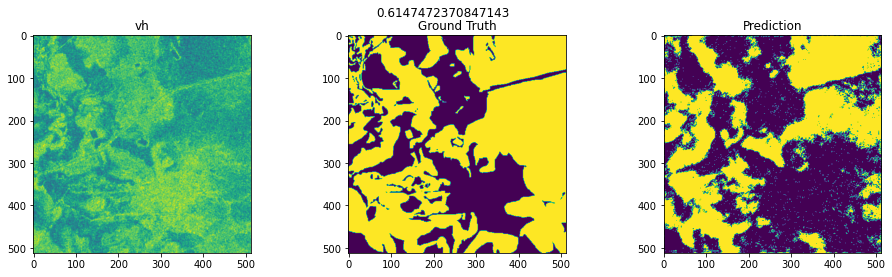

In [157]:
plot_preds()

Awesome, we got back our prediction and we can compare it to the ground truth. We could definitely do better if we spend time adding extra data to our dataset and I have a lot of other ideas on what we can do to improve, but I will mention that in the conclusion of this notebook. Since this project is more focused on creating an end-to-end SageMaker project, I will not bother improving the performance of the model in SageMaker (too costly; will potentially continue working on this project in Google Colab).

Before we conclude, I wanted to share a small webapp I created with streamlit and Docker. No need to run those files, but I figured it would be a good addition to this project.

# Streamlit App

I built a streamlit app (which you can find in the `./app` directory. The app allows you to load your images you would like to predict and displays the predicted image along with the vh polarization image and the the ground truth.

Here we start by clicking on "Browse files" and load the vv, vh and label_mask images for prediction.

<img src="https://raw.githubusercontent.com/JayThibs/map-floodwater-sar-imagery-on-sagemaker/main/imgs/st-load-images.png" alt="st-load-images" width="500"/>

Once the images are loaded, the app will send a request to the endpoint via the SageMaker SDK and we will receive a prediction from the endpoint. Our prediction is to the right of the image (we also have vh and ground truth):

<img src="https://raw.githubusercontent.com/JayThibs/map-floodwater-sar-imagery-on-sagemaker/main/imgs/st-prediction-efficientnet-b0.png" alt="st-prediction-efficientnet-b0.png" width="500"/>

Once we've predicted on an image, we can click "Try with New Images" and it will clear the cache so that we can load new images for prediction.

<img src="https://raw.githubusercontent.com/JayThibs/map-floodwater-sar-imagery-on-sagemaker/main/imgs/st-note-try-new-images.png" alt="st-note-try-new-images.png" width="500"/>

We could improve this webapp by:

* allowing the user to load all images at once and then choosing which ones they would like to predict
* storing the predictions in a database

This is the main code for the streamlit webapp:

In [200]:
!pygmentize ./app/app.py

import streamlit as st
from streamlit import caching
import numpy as np
import os
import re
import rasterio
from sagemaker.predictor import Predictor
from sagemaker.serializers import NumpySerializer
from sagemaker.deserializers import JSONDeserializer
from utils import plot_preds

st.title("Floodwater Mapping with SAR Imagery")
st.markdown("***")

st.subheader("Upload the vv and vh Polarization Images as well as the ground truth.")
uploaded_files = st.file_uploader(" ", accept_multiple_files=True)
print("Uploaded file:", uploaded_files)

x_arr = None
ENDPOINT_NAME = ""  # os.environ["ENDPOINT_NAME"]
AWS_DEFAULT_REGION = "us-east-1"  # os.environ["AWS_DEFAULT_REGION"]

if len(uploaded_files) == 3:

    print(uploaded_files)
    mask_regex = "[a-z]+\d+.tif"

    for file in uploaded_files:

        if file.name.endswith("vv.tif"):
            with rasterio.open(file) as vv:
                vv_img = vv.read(1)
                print(type(vv_img))
                print("Loaded vv image.")


# Delete Endpoint

In [160]:
predictor.delete_endpoint()

# Conclusion

And there we have it! We've completed the project by successfully training models and deploying them on SageMaker.

Here's a summary of what we did:

* Data exploration on SAR images
* Preprocessed the data
* Loaded data to S3
* Trained two models using SageMaker's HyperparameterTuning function
* Selected the best model for deployment
* Deployed model
* Performed inference on the deployed model in the notebook
* Performed inference on the deployed model in the streamlit webapp

Our main focus for this project was to get used to using SageMaker's features as well as the relevant AWS services. This means that there are obviously a lot of things we could improve in this project, but I decided to limit the project in order to focus on the most important things I wanted to learn. Though it was not mentioned in the notebook, I did a lot of debugging for the training and deployment of the models using CloudWatch.

Here's what we could do to improve this project even further:

* Use an ensemble of the models (I tried to do this, but deployed ensembles are a little complicated in SageMaker and the documentation is not too clear so I decided I would only deploy a single model).
* If we use an ensembled model, we can decide to use the max value of either model in the ensemble since this will bias towards predicting floodwater. Based on the predictions we get from the model, it seems that the model is more likely to miss predicting floodwater over non-floodwater. Therefore, it would make sense to choose the max in case one of the models is predicting floodwater and another one (incorrectly) isn't.
* Train many more models using different albumentations, backbone models, architectures (head), and loss functions.
* Setup a lambda + API Gateway endpoint to reduce the cost per API call.
* Send a continuous stream of images through our model endpoint as if we are using the endpoint to predict flooding in real-time in order to save lives and reduce damages.
* We could use the additional data from Microsoft Planetary Computer. In particular, the Nasadem band is an incredibly important.
* And many more improvements!

And that's it! I learned a lot about computer vision and semantic segmentation for this project, but I also learned a lot about SageMaker. There was a lot of debugging involved, but I consider that to be crucial experience for a machine learning engineer and I'm grateful I was able to get over that hurdle. I will bring the skills learned with me and surely use them again in the future!